In [1]:
%matplotlib inline
#some basic imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

#TODO: add your imports here


#seting up some styles
import seaborn as sns
sns.set_context("paper")
sns.set_style("whitegrid")

#avoid Font-problem in plots for ACM/IEEE papers
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

experiment_name = "Tracing"

In [2]:
from load import load
activations,perfromance = load()

experimentes = perfromance["experiment"].unique()

## Experiment Plots

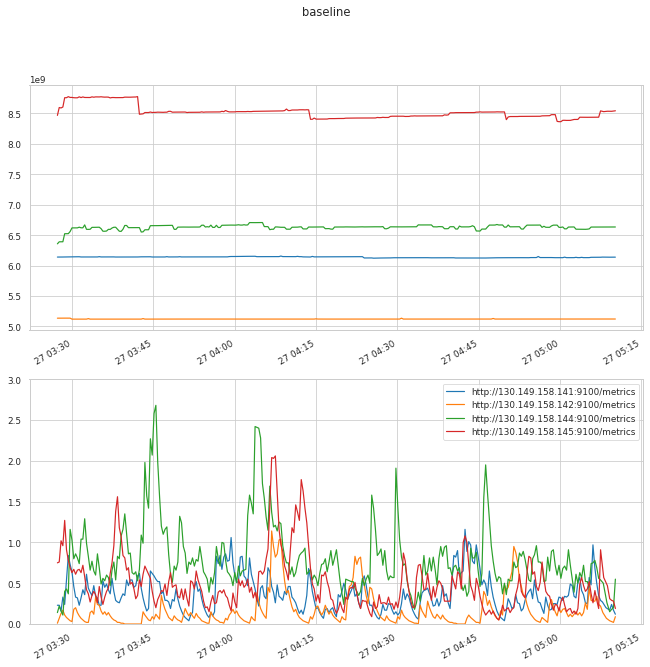

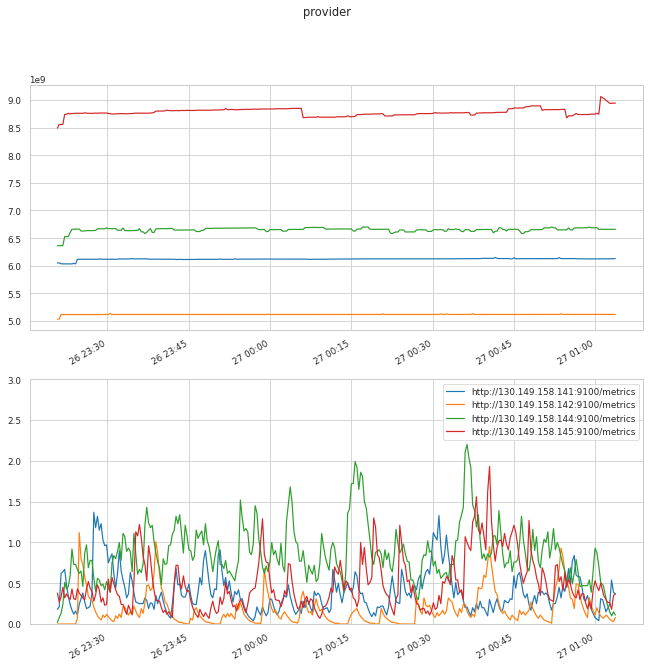

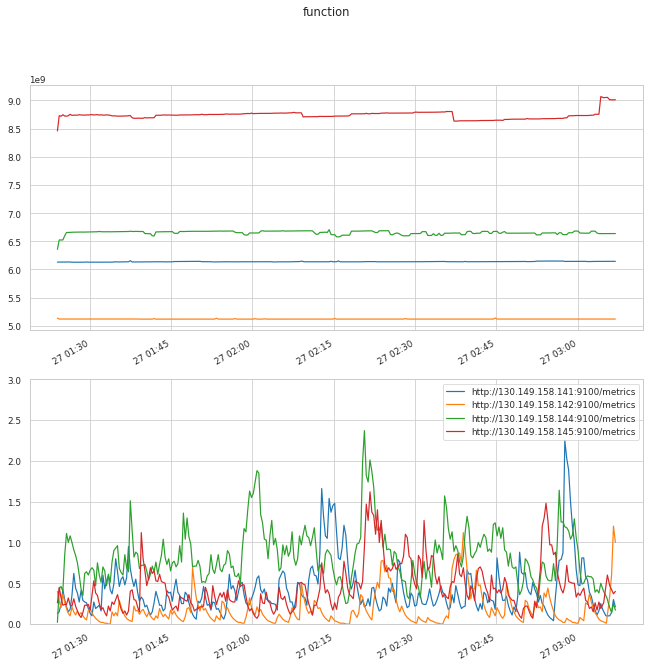

In [9]:
for exp in experimentes:
    fig = plt.figure(figsize=(11,11))
    gs = fig.add_gridspec(ncols=1, nrows=2,hspace=0.20)
    X = perfromance[perfromance["experiment"] == exp]
    mem = X.groupby(["node"]).resample("5m")["node_memory_Active"]
    ax = fig.add_subplot(gs[0])
    mem.plot(ax=ax)

    cpu = X.groupby(["node"]).resample("5m")["node_load1"]
    ax = fig.add_subplot(gs[1])
    cpu.plot(ax=ax)
    ax.set_ylim([0.0,3.0])
    plt.legend()
    plt.suptitle(exp)



In [10]:
activations['start'] = pd.to_datetime(activations['timestamp_start'])

activations['end'] = pd.to_datetime(activations['timestamp_stop'])

activations["ELat"] = (activations["end"] - activations["start"]).dt.total_seconds()

activations.groupby(["experiment"])["ELat"].describe()


,count,mean,std,min,25%,50%,75%,max
experiment,,,,,,,,
baseline,100.0,1.521691,2.648009,0.070078,0.355021,0.417712,0.549002,11.543093
function,100.0,1.100017,2.222702,0.076145,0.389762,0.420456,0.569554,16.765612
provider,100.0,1.286702,2.412105,0.117869,0.424474,0.481972,0.605065,16.081650


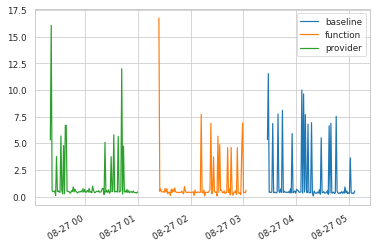

In [12]:
activations.set_index("start").groupby(["experiment"]).resample("5m")["ELat"].plot()
plt.legend()